# ** Vehicle Detection **

In [714]:
import numpy as np
import cv2
import glob
import copy
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time
import datetime
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

# Using scikit-learn >= 0.18
from sklearn.model_selection import train_test_split

# Define test path and files

test_files = 'test_images/test*.jpg'

# Define car path and files
# Note that all the cars and noncars images are stored under a single /train directory but each have their
# own subdirectories beneath that
car_notcar_files = 'examples/train/*/*/*'

# This fifo tracks heat maps in a queue of pre-determined size
n_fifo = 10
heatmap_fifo = deque([], n_fifo)

# * Exploration Functions - visualization *

In [2]:
def visualise_test_images(files):
    
    # Define test image filename
    images = glob.glob(files)
    
    # Step through the list and plot images
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(fname)
        plt.show()

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = (0, 0, 0)
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = None
    
    test_image = mpimg.imread(cars[0])  # any image will do so just pick first in the list
    data_dict["image_shape"] = test_image.shape
    data_dict["data_type"] = type(test_image[0][0][0])  # any pixel in 3-channel will do so pick the first
    # Return data_dict
    return data_dict

def visualise_car_and_notcar(files):

    #from skimage.feature import hog
    #from skimage import color, exposure
    # images are divided up into vehicles and non-vehicles

    images = glob.glob(files, recursive=True)
    cars = []
    notcars = []

    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)
    
    print(notcars[0])
        
    data_info = data_look(cars, notcars)

    print('Your function returned a count of', 
          data_info["n_cars"], ' cars and', 
          data_info["n_notcars"], ' non-cars')
    print('of size: ',data_info["image_shape"], ' and data type:', 
          data_info["data_type"])
    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    
    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')
    plt.show()


# * Class Functions - feature handling and bbox drawing *

In [607]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='HLS', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# * Main Execution begins here *

In [4]:
images = glob.glob(car_notcar_files, recursive=True)
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
print('Number of Cars:',len(cars))
print('Number of NotCars:',len(notcars))

Number of Cars: 2826
Number of NotCars: 14934


In [5]:
# Notice the imbalance in number of cars and notcars

examples/train/non-vehicles/Extras/extra3495.png
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: <class 'numpy.float32'>


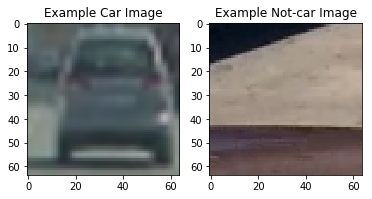

In [6]:
#visualise_test_images(test_files)
visualise_car_and_notcar(car_notcar_files)

In [7]:
def augment(x, n):
    poolsize = len(x)
    new_x = copy.deepcopy(x)
    
    for i in range(n):
        random_i = int(np.random.uniform(0.0, 1.0, None)*poolsize)
        new_x.append(x[random_i])
    return new_x

In [8]:
cars = augment(cars, len(notcars)-len(cars))

# Now cars has same size as notcars
# proceed with feature extraction using 

# For initial testing only reduce the sample size
# To be removed when ready
#sample_size = 2000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

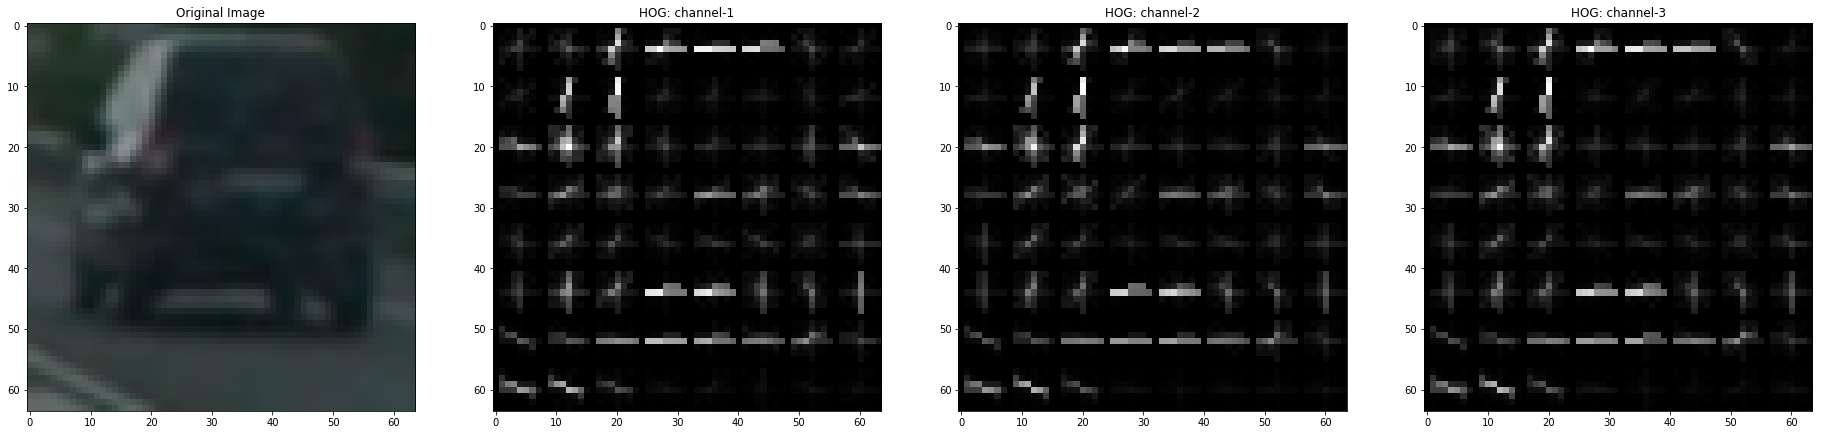

In [606]:
# choose random car and random non-car and visualize hog implementation with the following parameters
#import np.random.random_integers

random_car_index = np.random.random_integers(0, len(cars)+1)
car_image = mpimg.imread(cars[random_car_index])
ch1 = car_image[:,:,0]
ch2 = car_image[:,:,1]
ch3 = car_image[:,:,2]

random_notcar_index = np.random.random_integers(0, len(notcars)+1)
notcar_image = mpimg.imread(notcars[random_notcar_index])

# set hog parameters
test_orient = 12
test_pix_per_cell = 8
test_cell_per_block = 2

test_car_hog_features_ch1, test_car_hog_img_ch1= get_hog_features(ch1, test_orient, test_pix_per_cell, test_cell_per_block, True, True)
test_car_hog_features_ch2, test_car_hog_img_ch2 = get_hog_features(ch2, test_orient, test_pix_per_cell, test_cell_per_block, True, True)
test_car_hog_features_ch3, test_car_hog_img_ch3 = get_hog_features(ch3, test_orient, test_pix_per_cell, test_cell_per_block, True, True)


fig = plt.figure(figsize=(32, 120))

plt.subplot(141)
plt.imshow(car_image)
plt.title("Original Image")

# plot channel-1
plt.subplot(142)
plt.imshow(test_car_hog_img_ch1, cmap='gray')
plt.title("HOG: channel-1")
        
# plot channel-2
plt.subplot(143)
plt.imshow(test_car_hog_img_ch2, cmap='gray')
plt.title("HOG: channel-2")

# plot channel-3
plt.subplot(144)
plt.imshow(test_car_hog_img_ch3, cmap='gray')
plt.title("HOG: channel-3")
plt.show()


# ** Training Begins Here **

/home/neo/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
44.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9943


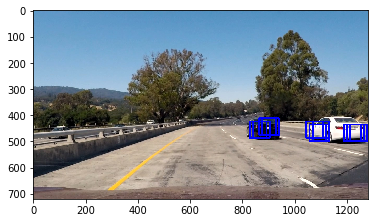

In [504]:
# HSV 0
# YUV 2
# HLS 2
# * LUV 0
save_params = True

# Initial Good Choice: mostly gets both cars but misses the white small, lots of false positive on empty image
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # 9 HOG orientations
pix_per_cell = 9 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # (16,16) Spatial binning dimensions
hist_bins = 32  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.75, 0.75) # Default (0.5, 0.5)


# some falses but there is a heat map
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # 9 HOG orientations
pix_per_cell = 8 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 16  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.8, 0.8) # Default (0.5, 0.5)

# missed white car some times and requires heatmap threshold
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # 9 HOG orientations
pix_per_cell = 8 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 16  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.8, 0.8) # Default (0.5, 0.5)

# good amount of frames detected but still a number of false postives, head to play with thresh = 3
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # 9 HOG orientations
pix_per_cell = 16 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 16  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.8, 0.8) # Default (0.5, 0.5)


# problem detecting black
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # 9 HOG orientations
pix_per_cell = 8 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 32  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.8, 0.8) # Default (0.5, 0.5)

# mostly gets both cars but lots of false positive on empty image
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # 9 HOG orientations
pix_per_cell = 9 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 16  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.75, 0.75) # Default (0.5, 0.5)

# way more false positives when looking only at channel 3
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # 9 HOG orientations
pix_per_cell = 16 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 32  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.5, 0.7) # Default (0.5, 0.5)

# decent hitting all cars with only a fewer false positives but white could be detected more frequently
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # 9 HOG orientations
pix_per_cell = 16 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 32  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.5, 0.7) # Default (0.5, 0.5)

# still decent but lost black detection on one sample, so increasing spatial size doesn't always help
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # 9 HOG orientations
pix_per_cell = 16 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # (16,16) Spatial binning dimensions
hist_bins = 32  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.5, 0.7) # Default (0.5, 0.5)

# reduced spatial binning helped bring ack black detection but increased false positives
# also changed the overlap ratio.  this may also contribute to false positives
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # 9 HOG orientations
pix_per_cell = 16 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 32  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.6, 0.8) # Default (0.5, 0.5)

# pretty good but we could use more hits on image5 white car
# could to increase x overlap
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # 9 HOG orientations
pix_per_cell = 16 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 16  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.6, 0.8) # Default (0.5, 0.5)

# decent but had some hard time with small white in image4
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # 9 HOG orientations
pix_per_cell = 16 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 16  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.75, 0.8) # Default (0.5, 0.5)

# Best result:
# Using: 12 orientations 8 pixels per cell and 2 cells per block
# Feature vector length: 7872
# 44.04 Seconds to train SVC...
# Test Accuracy of SVC =  0.9943
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # 9 HOG orientations
pix_per_cell = 8 # 8 HOG pixels per cell
cell_per_block = 2 # 2 HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # (16,16) Spatial binning dimensions
hist_bins = 16  # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 640] # Min and max in y to search in slide_window()
xy_window=(64, 64) # Keep this at (64, 64) during training because training images are 64x64
xy_overlap=(0.8, 0.8) # Default (0.5, 0.5)


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
# 1 = car, 0 = notcar
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
# 80% train, 20% test
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
validation_accuracy = round(svc.score(X_test, y_test), 4)
print('Test Accuracy of SVC = ', validation_accuracy)
# Check the prediction time for a single sample
t=time.time()

# Save classifier parameters if save_params=True, otherwise don't save
if save_params:
    classifier_params = {'svc': svc, 'X_scaler': X_scaler, 'color_space': color_space, 'orient': orient,
                       'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'hog_channel': hog_channel,
                       'spatial_size': spatial_size, 'hist_bins': hist_bins, 'spatial_feat': spatial_feat,
                       'hist_feat': hist_feat, 'hog_feat': hog_feat, 'y_start_stop': y_start_stop,
                       'xy_window': xy_window, 'xy_overlap': xy_overlap, 'validation_accuracy': validation_accuracy}

    #ts = datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d_%H:%M:%S')
    #pickle.dump(classifier_params,open('classifier_params_' + ts + '.p', "wb"))
    pickle.dump(classifier_params,open('classifier_params.p', "wb"))


image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

/home/neo/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


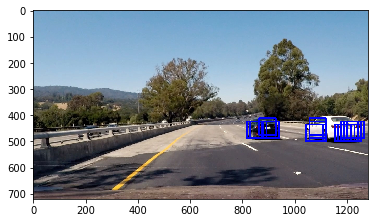

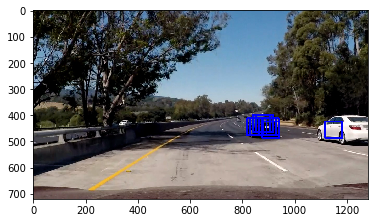

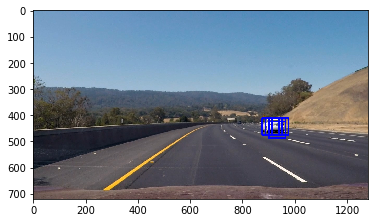

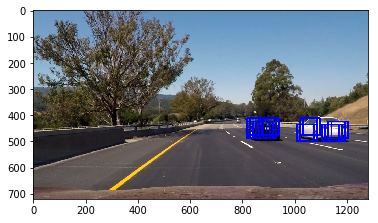

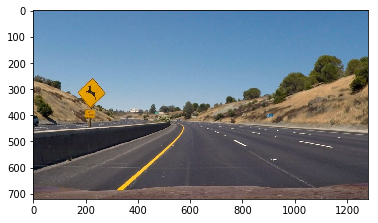

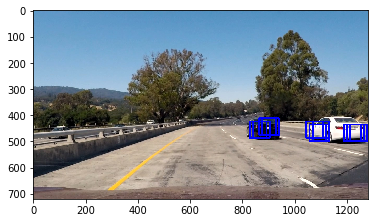

In [505]:
# Define test image filename
images = glob.glob(test_files)

# Step through the list and plot images
for idx, fname in enumerate(images):
    image = mpimg.imread(fname)
        
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.show()

In [573]:
# retrieve previously pickled classifer and its parameters for production use
good_classifier_file = 'classifier_params_YCrCb_good_detection.p'

# load last known classifier

classifier_file = open(good_classifier_file,'rb')
classifier_params = pickle.load(classifier_file)
classifier_file.close()
classifier_params

{'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'cell_per_block': 2,
 'color_space': 'YCrCb',
 'hist_bins': 16,
 'hist_feat': True,
 'hog_channel': 'ALL',
 'hog_feat': True,
 'orient': 12,
 'pix_per_cell': 8,
 'spatial_feat': True,
 'spatial_size': (16, 16),
 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'validation_accuracy': 0.99429999999999996,
 'xy_overlap': (0.8, 0.8),
 'xy_window': (64, 64),
 'y_start_stop': [400, 640]}

# ** Find Cars Function **

In [507]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, hog_feat, hist_feat, spatial_feat, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins):
    bboxes = () # list of bounding boxes
    
    # draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2'+color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel=="ALL":
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel==0:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel==1:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel==2:
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel=="ALL":
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel==0:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1))
            elif hog_channel==1:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat2))
            elif hog_channel==2:
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features_tuple = ()
            if spatial_feat:
                test_features_tuple = test_features_tuple + (spatial_features,)
            if hist_feat:
                test_features_tuple = test_features_tuple + (hist_features,)
            if hog_feat:
                test_features_tuple = test_features_tuple + (hog_features,)
                
            test_features = X_scaler.transform(np.hstack(test_features_tuple).reshape(1, -1))
            test_prediction = svc.predict(test_features)
    
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                # Instead of plotting and returning the annoted image, just return the box coordinates and accumulate them outside
                # during the scaling process.  We apply heat map functions on those accumulated boxes and then eventually plot outside
                bboxes = bboxes + (((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)), )
    return bboxes

# ** Heat Map Functions **

In [508]:
def add_heat(heatmap, bbox_list):
    """ Hotter areas correspond to multiple boxes detected in that space.
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    """ This will remove areas without heat above the threshold.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """ Drawing the boxes onto an image.
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [731]:
def process_image(img):
    global classifier_params # this contains the parameters for find_cars
    global heatmap_fifo, n_fifo
    
    visualise = False
    
    # unpickle and get parameters
    ystart = classifier_params['y_start_stop'][0]
    ystop = classifier_params['y_start_stop'][1]
    svc = classifier_params['svc'] # the trained classifier
    X_scaler = classifier_params['X_scaler']
    color_space = classifier_params['color_space']
    hog_feat = classifier_params['hog_feat']
    hist_feat = classifier_params['hist_feat']
    spatial_feat = classifier_params['spatial_feat']
    orient = classifier_params['orient']
    pix_per_cell = classifier_params['pix_per_cell']
    cell_per_block = classifier_params['cell_per_block']
    hog_channel = classifier_params['hog_channel']
    spatial_size = classifier_params['spatial_size']
    hist_bins = classifier_params['hist_bins']
    
    # Define scales too run through as we scale our search window
    
    # the following scale works well with classifier_params_YCrCb_good_detection.p
    # scales = (0.95, 1.0, 1.2, 1.5, 1.7, 2.0, 2.3, 2.6, 3.0, 3.5)
    scales = (0.85, 1.0, 1.2, 1.5, 1.7, 2.0, 2.3)
    
    
    bboxes = () # to collect all bounding boxes across all scales for this one image
    
    # iterate through scales and call find_cars on each scale factor.  Each time around collect all the
    for scale in scales:
        bboxes = bboxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, hog_feat, hist_feat, spatial_feat, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

    # Threshold for strength of heat needed to make it to final bounding box
    # Helps remove false positives
    heat_threshold = 4
    
    # begin heatmap

    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heatmap = add_heat(heatmap,bboxes)

    # Append new heatmap to fifo of heatmaps
    heatmap_fifo.appendleft(heatmap)
        
    # mean heatmap
    mean_heatmap = np.mean(heatmap_fifo, axis=0)

    # Apply threshold to help remove false positives
    mean_heatmap = apply_threshold(mean_heatmap,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(mean_heatmap, 0, 255)
    

    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if visualise:
        # plot heatmap
        fig = plt.figure(figsize=(32, 96))
        plt.subplot(131)
        plt.imshow(heatmap, cmap='hot')
        plt.title("Heatmap:"+str(heatmap.max()))
        
        # plot label
        plt.subplot(132)
        plt.imshow(labels[0], cmap='gray')
        plt.title('Labels: '+str(labels[1])+' cars found')
        
        plt.subplot(133)
        plt.imshow(draw_img)
        plt.title("Find Car Overlay with Original Image")
        
        plt.show()


    return draw_img

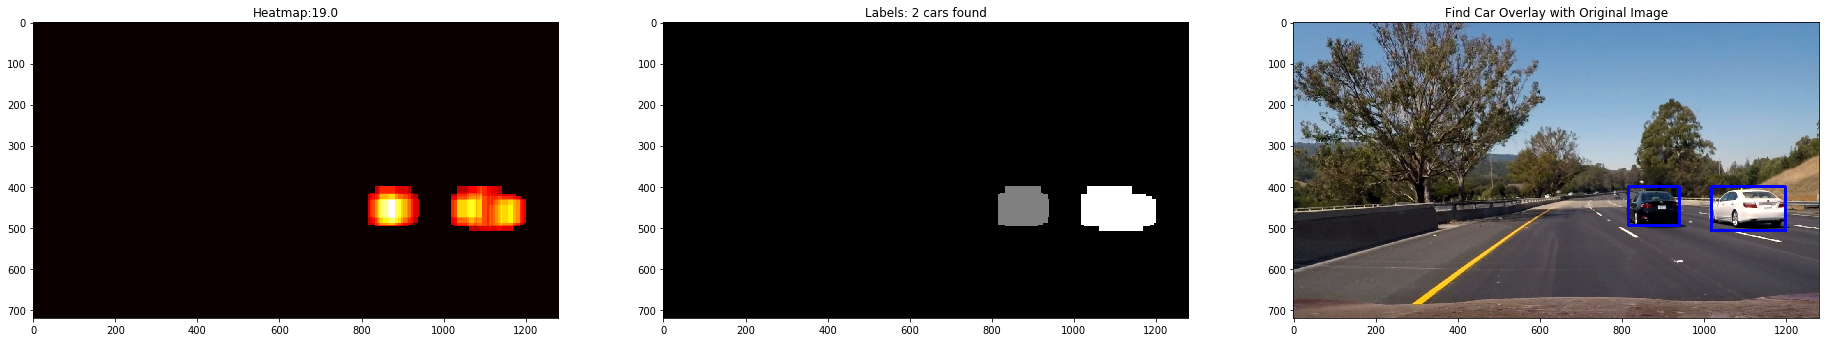

In [725]:
image = mpimg.imread('test_images/test6.jpg')

# unpickle and get parameters
ystart = classifier_params['y_start_stop'][0]
ystop = classifier_params['y_start_stop'][1]
svc = classifier_params['svc'] # the trained classifier
X_scaler = classifier_params['X_scaler']
hog_feat = classifier_params['hog_feat']
hist_feat = classifier_params['hist_feat']
spatial_feat = classifier_params['spatial_feat']
orient = classifier_params['orient']
pix_per_cell = classifier_params['pix_per_cell']
cell_per_block = classifier_params['cell_per_block']
hog_channel = classifier_params['hog_channel']
spatial_size = classifier_params['spatial_size']
hist_bins = classifier_params['hist_bins']

# when testing reset the lifo queue to reset or else we get bias from previous test runs
heatmap_fifo = deque([], n_fifo)
f = process_image(image)

In [733]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')

# ensure fifo queue is cleared before actual processing
heatmap_fifo = deque([], n_fifo)
lane_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4



 12%|█▏        | 152/1261 [06:19<46:14,  2.50s/it]


 24%|██▍       | 303/1261 [12:37<39:49,  2.49s/it]


 36%|███▌      | 454/1261 [18:53<33:58,  2.53s/it]


 48%|████▊     | 605/1261 [25:12<27:19,  2.50s/it]


 60%|█████▉    | 756/1261 [31:27<20:54,  2.48s/it]


 72%|███████▏  | 907/1261 [37:46<14:40,  2.49s/it]


 84%|████████▍ | 1057/1261 [44:00<08:27,  2.49s/it]


 96%|█████████▌| 1205/1261 [50:11<02:19,  2.49s/it]


100%|█████████▉| 1260/1261 [52:29<00:02,  2.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 52min 45s, sys: 6.21 s, total: 52min 52s
Wall time: 52min 30s
